In [1]:
import json
import numpy as np
import torch
import os, sys, shutil

from tensorboardX import SummaryWriter
from time import sleep
from torch import optim
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils import data
from tqdm import tqdm
import torch.distributions as D

import data as data_
import nn as nn_
import utils
from mfp_utils import *

from experiments import cutils
from nde import distributions, flows, transforms

import klampt
from klampt.plan import cspace, robotplanning
from klampt.plan.robotcspace import RobotCSpace
from klampt.model import collide
from klampt.model.trajectory import RobotTrajectory
from klampt.io import resource

from mfg_models import construct_Q

In [2]:
import argparse
import sys
parser = argparse.ArgumentParser()
# 模拟命令行输入
sys.argv = ['--exp_name 2D --linear_transform_type lu_no_perm --reg_OT_dir gen --num_training_steps 1000 --base_transform_type rq-coupling --tail_bound 5 --OT_part block_CL_no_perm --lbd_OT 2e-1 --gaussian_multi_dim 2 --num_train_data 2000 --LU_last false --NF_loss jeffery --lr_schedule adaptive --train_batch_size 2048 --learning_rate 1e-3']
# data
parser.add_argument('--exp_name', type=str, default='2D')
parser.add_argument('--dataset_name', type=str, default='gaussian_mixture',
                    choices=['gaussian_mixture', 'crowd_motion_gaussian', 'crowd_motion_gaussian_close'
                            'crowd_motion_gaussian_nonsmooth_obs', 'moons', 
                            'gaussian', '2spirals', 'checkerboard',
                            'power', 'gas', 'hepmass', 'miniboone', 'bsds300',
                            'robot_1'],
                    help='Name of dataset to use.')
parser.add_argument('--val_frac', type=float, default=1.,
                    help='Fraction of validation set to use.')

# optimization
parser.add_argument('--learning_rate', type=float, default=1e-3,
                    help='Learning rate for optimizer.')
parser.add_argument('--num_training_steps', type=int, default=1000,
                    help='Number of total training steps.')
# parser.add_argument('--anneal_learning_rate', type=int, default=1,
#                     choices=[0, 1],
#                     help='Whether to anneal the learning rate.')
parser.add_argument('--lr_schedule', type=str, default='adaptive',
                    choices=['none', 'cyclic', 'adaptive'])
parser.add_argument('--grad_norm_clip_value', type=float, default=5.,
                    help='Value by which to clip norm of gradients.')
parser.add_argument('--lbd_reg', type=float, default=0)


# flow details
parser.add_argument('--base_transform_type', type=str, default='rq-coupling',
                    choices=['affine-coupling', 'quadratic-coupling', 'rq-coupling',
                             'affine-autoregressive', 'quadratic-autoregressive',
                             'rq-autoregressive'],
                    help='Type of transform to use between linear layers.')
parser.add_argument('--linear_transform_type', type=str, default='lu_no_perm',
                    choices=['permutation', 'lu', 'svd', 'lu_no_perm'],
                    help='Type of linear transform to use.')
parser.add_argument('--num_flow_steps', type=int, default=7,
                    help='Number of blocks to use in flow.')
parser.add_argument('--hidden_features', type=int, default=256,
                    help='Number of hidden features to use in coupling/autoregressive nets.')
parser.add_argument('--tail_bound', type=float, default=5,
                    help='Box is on [-bound, bound]^2')
parser.add_argument('--num_bins', type=int, default=8,
                    help='Number of bins to use for piecewise transforms.')
parser.add_argument('--num_transform_blocks', type=int, default=2,
                    help='Number of blocks to use in coupling/autoregressive nets.')
parser.add_argument('--use_batch_norm', type=int, default=0,
                    choices=[0, 1],
                    help='Whether to use batch norm in coupling/autoregressive nets.')
parser.add_argument('--dropout_probability', type=float, default=0.25,
                    help='Dropout probability for coupling/autoregressive nets.')
parser.add_argument('--apply_unconditional_transform', type=int, default=1,
                    choices=[0, 1],
                    help='Whether to unconditionally transform \'identity\' '
                         'features in coupling layer.')
parser.add_argument('--base_net_act', type=str, default='relu',
                    choices=['relu', 'tanh'])

# logging and checkpoints
parser.add_argument('--monitor_interval', type=int, default=250,
                    help='Interval in steps at which to report training stats.')

# reproducibility
parser.add_argument('--seed', type=int, default=1638128,
                    help='Random seed for PyTorch and NumPy.')

# MFG
parser.add_argument('--gaussian_multi_dim', type=int, default=2)
parser.add_argument('--gaussian_multi_a',   type=float, default=10.)
parser.add_argument('--num_train_data',     type=int, default=2000)
parser.add_argument('--num_val_data',       type=int, default=10000)
parser.add_argument('--num_test_data',      type=int, default=10000)
parser.add_argument('--train_batch_size',   type=int, default=2048)
parser.add_argument('--val_batch_size',     type=int, default=512)
parser.add_argument('--test_batch_size',    type=int, default=512)
parser.add_argument('--lbd_OT',             type=float, default=2e-1)
parser.add_argument('--lbd_F',              type=float, default=0)
parser.add_argument('--lbd_F_E',            type=float, default=0.01)
parser.add_argument('--lbd_F_P',            type=float, default=1)
parser.add_argument('--reg_OT_dir',         type=str, default='gen', choices=['gen', 'norm'])
parser.add_argument('--OT_comp',            type=str, default='trajectory', choices=['trajectory', 'monge'])
parser.add_argument('--OT_part',            type=str, default='block_CL_no_perm', choices=['block', 'block_CL_no_perm', 'module'])
parser.add_argument('--interaction',        type=lambda x: (str(x).lower() == 'true'), default=False)
parser.add_argument('--LU_last',            type=lambda x: (str(x).lower() == 'true'), default=False)
parser.add_argument('--NF_loss',            type=str, default='jeffery', choices=[
                                            'KL_sampling', 'KL_density', 'jeffery'])
parser.add_argument('--val_score',          type=str, default='loss', choices=[
                                            'loss', 'L', 'G', 'F'])
parser.add_argument('--mixture_base',       type=str, default='gaussian', choices=[
                                            'gaussian', 'gaussian_mixture'])
parser.add_argument('--mixture_weight',     type=str, default='identical', choices=[
                                            'identical', 'undersample_one'])  
parser.add_argument('--F_ld_weight',        type=str, default='identical', choices=['identical'])                                                                          
parser.add_argument('--disc_scheme',        type=str, default='forward', choices=[
                                            'forward', 'centered', 'forward_2nd',
                                            'FD4_simp', 'FD1_simp', 'FD4_simp_symmetric'])
parser.add_argument('--NF_model',           type=str, default='default', choices=[
                                            'default', 'single_flow'])                                     
parser.add_argument('--obs_nonsmooth_val',  type=float, default=100.)
parser.add_argument('--interp_hist',        type=lambda x: (str(x).lower() == 'true'), default=False)
parser.add_argument('--n_interp',           type=int, default=5, 
                    help='Number of interpolated points inserted between flow points to better approximate MFG costs')
## robotics
parser.add_argument('--robot_init_pos',     type=str, default='default', choices=['default', 
                                            'under_table', 'under_table_2', 'under_table_3', 'under_table_4',
                                            'under_table_hard']) 
parser.add_argument('--robot_term_pos',     type=str, default='cup', choices=['cup']) 
parser.add_argument('--robot_var',          type=float, default=1e-5)
parser.add_argument('--robot_obs_val',      type=float, default=1e2)
parser.add_argument('--robot_1_obs',        type=str, default='thick_sigmoid_B=256')
parser.add_argument('--robot_1_obs_l',      type=int, default=3)
parser.add_argument('--robot_1_obs_act',    type=str, default='relu', choices=['relu', 'tanh'])
parser.add_argument('--robot_1_base_dist',  type=str, default='default', choices=['default', 'two_init'])
parser.add_argument('--obs_robot_sig',      type=lambda x: (str(x).lower() == 'true'), default=True) 

# misc.
parser.add_argument('--plotting_subset',    type=int, default=10000)
parser.add_argument('--load_best_val',      type=lambda x: (str(x).lower() == 'true'), default=False)
parser.add_argument('--compute_lip_bound',  type=lambda x: (str(x).lower() == 'true'), default=False)
parser.add_argument('--save_train_traj',    type=lambda x: (str(x).lower() == 'true'), default=False)
parser.add_argument('--syn_noise',          type=float, default=0.1)
parser.add_argument('--marker_size',        type=float, default=5)
parser.add_argument('--color',              type=str, default='order', choices=[
                                            'order', 'radius'])
parser.add_argument('--tabular_subset',     type=lambda x: (str(x).lower() == 'true'), default=False)
parser.add_argument('--tensor_type',        type=str, default='float', choices=['float', 'double']) 

args = parser.parse_args()
args = sanitize_args(args)

In [3]:
# =================================================================================== #
#                                       Meta                                          #
# =================================================================================== #

os.environ['DATAROOT'] = 'experiments/dataset/data/'
os.environ['SLURM_JOB_ID'] = '1'

torch.manual_seed(args.seed)
np.random.seed(args.seed)

assert torch.cuda.is_available()
device = torch.device('cuda')
torch.set_default_tensor_type(torch.cuda.FloatTensor)

/home/am2l/anaconda3/envs/env1/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [4]:
import torch

# 检查CUDA是否可用，然后选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

import torch

# 假设 'cuda' 可用
if torch.cuda.is_available():
    device = torch.device("cuda")
    generator = torch.Generator(device=device)
else:
    device = torch.device("cpu")
    generator = torch.Generator(device=device)

# 使用这个生成器与 torch.randperm
rand_indices = torch.randperm(1, generator=generator)


Current device: cuda


In [5]:
# =================================================================================== #
#                                       Dataset                                       #
# =================================================================================== #
target_dist = None
space = None
num_mixtures = 8
weight = D.Categorical(torch.ones(num_mixtures,).to(device))
X_train, _, _, train_loader, val_loader, test_loader, target_dist = make_gaussian_mixture_data(args.mixture_base, args.gaussian_multi_dim, args.num_train_data, \
    args.num_val_data, args.num_test_data, args.train_batch_size, args.val_batch_size, args.test_batch_size, weight=weight)
train_generator = data_.batch_generator(train_loader)
train_loader
test_batch      = next(iter(train_loader)).to(device)
features        = args.gaussian_multi_dim

In [6]:
# =================================================================================== #
#                                       Model                                         #
# =================================================================================== #


# methods for chaining together the flow transformations
def create_linear_transform():
    return transforms.LULinear(features, identity_init=True)


def create_base_transform(i):
    act = F.relu


    return transforms.PiecewiseRationalQuadraticCouplingTransform(
        mask=utils.create_alternating_binary_mask(features, even=(i % 2 == 0)),
        transform_net_create_fn=lambda in_features, out_features: nn_.ResidualNet(
            in_features=in_features,
            out_features=out_features,
            hidden_features=args.hidden_features,
            context_features=None,
            num_blocks=args.num_transform_blocks,
            activation=act,
            dropout_probability=args.dropout_probability,
            use_batch_norm=args.use_batch_norm
        ),
        num_bins=args.num_bins,
        tails='linear',
        tail_bound=args.tail_bound,
        apply_unconditional_transform=args.apply_unconditional_transform
    )

def create_transform():
    flows = [
        transforms.CompositeTransform([
            create_linear_transform(),
            create_base_transform(i),
            create_base_transform(i+1)
        ]) for i in range(0, 2*args.num_flow_steps, 2)
    ]
      
    K = args.num_flow_steps
    transform = transforms.CompositeTransform(flows)

    return transform, K

# base dist

cov          = 0.3 * torch.eye(features).to(device)
mean         = torch.zeros(features).to(device)
distribution = distributions.MultivarNormal((features,), mean=mean, cov=cov)

# create flows
transform, K = create_transform()
flow = flows.Flow(transform, distribution).to(device)
n_params = utils.get_num_parameters(flow)
print('There are {} trainable parameters in this model.'.format(n_params))

# create optimizer
optimizer = optim.Adam(flow.parameters(), lr=args.learning_rate, weight_decay=args.lbd_reg)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, verbose=True)



There are 3774638 trainable parameters in this model.


In [7]:
print(K)
flow
# """
# Flow 类是一个包含变换和基础分布的模型。
# 它通常用于定义一个可逆的变换链（CompositeTransform），
# 以及一个简单的概率分布（_distribution），在这个例子中是多变量正态分布（MultivarNormal()）
# """

# """
# CompositeTransform：这是一个复合变换，它将多个变换组合在一起。
# 在此例子中，它包含了一个模块列表（ModuleList），其中每个模块也是一个 CompositeTransform。

# ModuleList (0-9)：ModuleList 包含了10个 CompositeTransform 对象，这表明模型中有10个相似的流程步骤或层，每个都执行相似的变换。
# """

# """ 
# 每个 CompositeTransform 包括：

# LULinear()：这是一个线性变换，通常用于进行可逆的线性操作，如LU分解。

# PiecewiseRationalQuadraticCouplingTransform (1-2)：包括两个此类型的变换，这类变换通常用于在保持一部分输入不变的同时，通过一种复杂的函数（在这里是由 ResidualNet 实现）修改输入的其余部分。

#     transform_net：一个 ResidualNet 网络，用于根据输入特征生成变换的参数。这个网络包括：
#         initial_layer：输入层，一个线性变换，将输入特征从1维扩展到256维。
#         blocks：包含多个 ResidualBlock，每个块包括两个线性层和一个Dropout层，用于增加模型的非线性和防止过拟合。
#         final_layer：输出层，另一个线性变换，将特征从256维压缩到23维。
#     unconditional_transform：一个 PiecewiseRationalQuadraticCDF，用于在变换中实现无条件的、复杂的可逆函数。
# """

7


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0-6): 7 x CompositeTransform(
        (_transforms): ModuleList(
          (0): LULinear()
          (1-2): 2 x PiecewiseRationalQuadraticCouplingTransform(
            (transform_net): ResidualNet(
              (initial_layer): Linear(in_features=1, out_features=256, bias=True)
              (blocks): ModuleList(
                (0-1): 2 x ResidualBlock(
                  (linear_layers): ModuleList(
                    (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
                  )
                  (dropout): Dropout(p=0.25, inplace=False)
                )
              )
              (final_layer): Linear(in_features=256, out_features=23, bias=True)
            )
            (unconditional_transform): PiecewiseRationalQuadraticCDF()
          )
        )
      )
    )
  )
  (_distribution): MultivarNormal()
)

In [8]:
# =================================================================================== #
#                                       Logging                                       #
# =================================================================================== #

# logging
timestamp = args.exp_name
log_dir   = os.path.join(cutils.get_log_root(), args.dataset_name, timestamp)

# remove previous TB records if desired
tbx_logging = True
if os.path.exists(log_dir):
    choice = input("Directory already exists. Use TBX to record again? (y/n)")
    if choice == 'y':
        choice = input("Do you wish to remove previous TB records at: " + log_dir + " ? (y/n)")
        if choice == 'y':
            # for filename in glob.glob(log_dir + "/events*"):
            #     os.remove(filename)
            shutil.rmtree(log_dir)
            sleep(5)
    else:
        tbx_logging = False
        writer      = None

while tbx_logging:
    try:
        writer = SummaryWriter(log_dir=log_dir, max_queue=20)
        writer.add_text(tag='args', text_string='CUDA_VISIBLE_DEVICES=0 python ' + " ".join(x for x in sys.argv))
        break
    except FileExistsError:
        sleep(5)
filename = os.path.join(log_dir, 'config.json')
with open(filename, 'w') as file:
    json.dump(vars(args), file)
print_args(sys.argv, save_dir=os.path.join(log_dir, 'args.txt'))

plot_data_dir = os.path.join(log_dir, 'plot_data/')
if not os.path.exists(plot_data_dir):
    os.makedirs(plot_data_dir)
plot_logger = Plot_logger(root_path=plot_data_dir)


# best_val_score = -1e10
best_val_score = 1e10

In [9]:
# =================================================================================== #
#                                      Training                                       #
# =================================================================================== #
def compute_loss(flow, data, args, mode='train'):
    # forward
    log_density, _, _, hist_norm, hist_ld_norm, OT_cost_norm, _ = flow.log_prob(data)
    # Distribution.log_prob, Flow._log_prob, Flow._transform(inputs, context=context), CouplingTransform.forward
    # return log_prob + logabsdet, log_prob, logabsdet, hist, hist_ld, OT_cost, noise
    log_density = torch.mean(log_density)

    # sample if needed
    z_K, ld_gen, OT_cost_gen, hist_gen, hist_ld_gen, z_0 = flow.sample(args.train_batch_size)
    # for idx in range(29):
    #     ld_gen -= hist_ld_gen[idx].squeeze()
    # print(ld_gen)
    # print('print(len(hist_ld_gen))',len(hist_ld_gen), hist_ld_gen[0].shape)
    # Distribution.sample, Flow._sample, Flow._transform.inverse, CouplingTransform.inverse
    # return samples, logabsdet, OT_cost, hist, hist_ld, noise
    # distribution matching / terminal cost (G)
    KL_density  = torch.Tensor([0]).to(device)
    KL_sampling = torch.Tensor([0]).to(device)
    
    log_prob_1  = torch.mean(target_dist.log_prob(data))
    log_prob_0   = torch.mean(distribution.log_prob(z_0))
    log_prob_gen = torch.mean(target_dist.log_prob(z_K))
    ld_gen       = torch.mean(ld_gen)
    KL_density   = - (log_prob_gen + ld_gen - log_prob_0)
    G_cost       = log_prob_1 - log_density + KL_density
    G_cost = - log_density - log_prob_gen

    # OT regularization (L)
    L_cost = torch.Tensor([0]).to(device)


    # sample a batch from the base to compute the OT cost
    hist   = hist_gen
    # print('hist.shape',len(hist),hist[0].shape)
    # part = torch.cat(hist).reshape(len(hist), hist[0].shape[0], hist[0].shape[-1]).permute(1,0,2) # B x K x d
    # K    = part.shape[1]
    # print(part.shape, K)
    # I = torch.arange(0, K, step=4)
    # print(I)
    # the OT cost returned by forward/sample is the module-wise cost
    L_cost, _ = compute_OT_cost(hist, args, mode=args.reg_OT_dir, partition_mode=args.OT_part, LU_last=args.LU_last,
                                        scheme=args.disc_scheme)
    # mode='gen', partition_mode=block_CL_no_perm, LU_last=false, scheme=forward
    L_cost = torch.mean(L_cost)

    # interaction (F)
    F_P    = torch.Tensor([0]).to(device)
    F_E    = torch.Tensor([0]).to(device)
    F_cost = torch.Tensor([0]).to(device)
    
    # Overall loss
    loss = G_cost + args.lbd_OT * L_cost + args.lbd_F * F_cost

    # logging with tensorboard
    # TODO: currently overwrites stuff for the validation set
    if tbx_logging:
        writer.add_scalar(tag='OT_cost' + '_' + mode, scalar_value=L_cost.item(), global_step=step)
        writer.add_scalar(tag='log_density'+ '_' + mode, scalar_value=log_density.item(), global_step=step)
        writer.add_scalar(tag='loss'+ '_' + mode, scalar_value=loss.item(), global_step=step)
        writer.add_scalar(tag='KL_density'+ '_' + mode, scalar_value=KL_density.item(), global_step=step)
        writer.add_scalar(tag='KL_sampling'+ '_' + mode, scalar_value=KL_sampling.item(), global_step=step)
        if args.interaction:
            writer.add_scalar(tag='F_P'+ '_' + mode, scalar_value=F_P.item(), global_step=step)
            writer.add_scalar(tag='F_E'+ '_' + mode, scalar_value=F_E.item(), global_step=step)
            writer.add_scalar(tag='F_cost'+ '_' + mode, scalar_value=F_cost.item(), global_step=step)

    # logging to .txt
    if mode == 'train':
        # only do this for training. Logging for validation data is done in the main loop.
        plot_logger.log(mode + '_steps', step)
        plot_logger.log(mode + '_NLL', float(-log_density))

    # return loss, G_cost, L_cost, F_cost
    return {'loss': loss, 'G': G_cost, 'L': L_cost, 'F': F_cost}

# main loop
for step in tqdm(range(args.num_training_steps), desc='Training Progress', unit='iter'):
    flow.train()
    optimizer.zero_grad()

    # grab data
    batch = next(train_generator).to(device)
    loss_dict = compute_loss(flow, batch, args, mode='train')
    loss      = loss_dict['loss']

    loss.backward()
    clip_grad_norm_(flow.parameters(), args.grad_norm_clip_value)
    optimizer.step()



Training Progress:   0%|          | 0/1000 [00:00<?, ?iter/s]/home/am2l/Documents/lcy/Generative-String-Net/src/nde/transforms/lu.py:85: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  outputs, _ = torch.triangular_solve(outputs.t(), lower, upper=False, unitriangular=True)
Training Progress: 100%|██████████| 1000/1000 [07:04<00:00,  2.36iter/s]


torch.Size([2048, 8, 2])


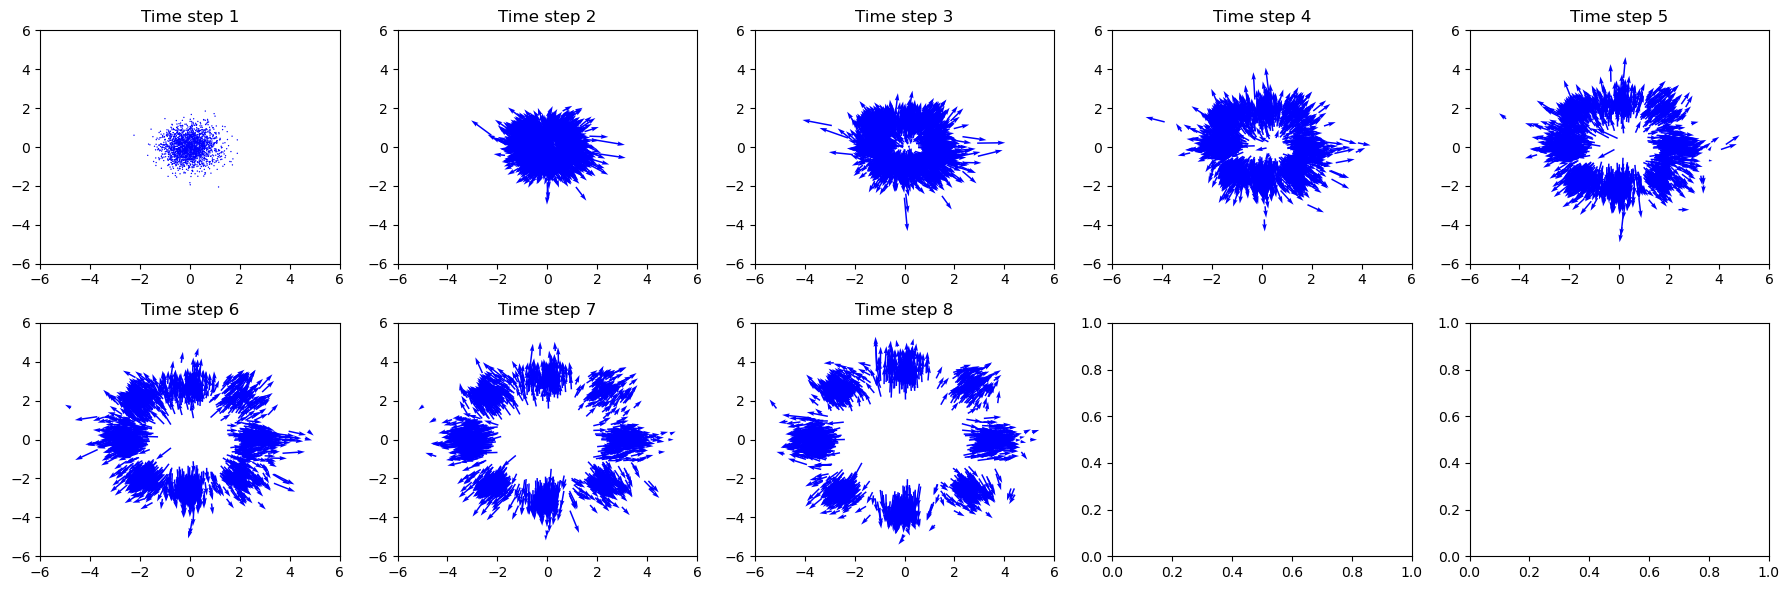

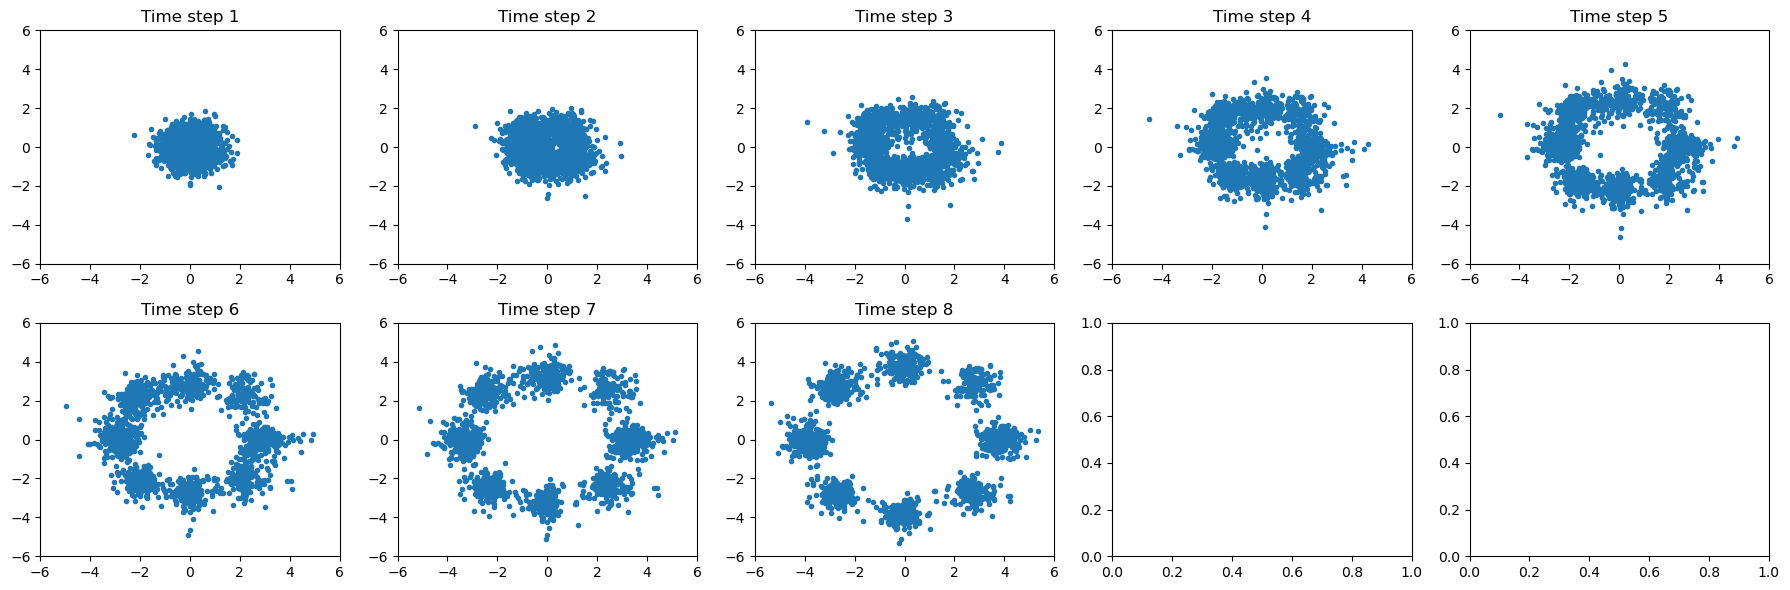

In [10]:
z_K, ld_gen, OT_cost_gen, hist_gen, hist_ld_gen, z_0 = flow.sample(args.train_batch_size)
hist = hist_gen
part = torch.cat(hist).reshape(len(hist), hist[0].shape[0], hist[0].shape[-1]).permute(1,0,2) # B x K x d
K    = part.shape[1]
I = torch.arange(0, K, step=4)
part = part[:,I,:]
print(part.shape)
import matplotlib.pyplot as plt
import torch


# 创建两个图形对象
fig1, ax1 = plt.subplots(2, 5, figsize=(18, 6))
fig2, ax2 = plt.subplots(2, 5, figsize=(18, 6))
x_plot = z_0.data.cpu().numpy()
for i in range(0,8):
    last_x = x_plot
    x_plot = part[:,i,:].data.cpu().numpy()


    U = x_plot[:, 0] - last_x[:, 0]
    V = x_plot[:, 1] - last_x[:, 1]
    ax = ax1.flatten()[i]  
    ax.quiver(last_x[:, 0], last_x[:, 1], U, V, scale=10, scale_units='width', color='b', width=0.005)
    # ax.grid(True)
    ax.set_title(f'Time step {i + 1}')
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

    ax = ax2.flatten()[i]  
    ax.plot(x_plot[:, 0], x_plot[:, 1], '.')
    # ax.grid(True)
    ax.set_title(f'Time step {i + 1}')
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

fig1.tight_layout()
# fig1.suptitle('First Set of Plots')
fig1.show()


fig2.tight_layout()
# fig2.suptitle('Second Set of Plots')
fig2.show()

